In [1]:
import scanpy as sc
import pandas as pd
import bbknn as bbknn
import numpy as np
import scipy.sparse as sp
import anndata
import warnings

DATA_PATH_23 = 'data/GSE239626/MTX'
DATA_PATH_13 = 'GSE138266'
RANDOM_STATE = 42

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# load reference dataset
adata_ref_GSE239626 = sc.read_10x_mtx(
    DATA_PATH_23,
    var_names='gene_symbols',
    gex_only=True,
    cache=True)

# add cluster labels (assigned by clustering on protein data of reference dataset)
cluster_label_GSE239626 = pd.read_csv('results/cluster_labels.csv', index_col=0)
adata_ref_GSE239626.obs['cluster_label'] = cluster_label_GSE239626

# add cell type labels (on reference dataset)
cell_types_labels = pd.read_csv('results/celltypist_labels_from_protein_Immune_All_High.csv')
adata_ref_GSE239626.obs['cell_types_labels'] = cell_types_labels['predicted_labels'].values

In [3]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

In [4]:
# new dataset to be integrated with the reference dataset and the cell type labels
adata_GSE138266 = sc.read(DATA_PATH_13) # 5 patients and 5 control: PBMC + CSF cells

In [5]:
adata_GSE138266

AnnData object with n_obs × n_vars = 814177 × 33694
    obs: 'sample', 'patient', 'dataset', 'disease', 'cell_type', 'batch'
    var: 'gene_symbols', 'gene_ids'

In [6]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

### Common Genes

In [7]:
adata_ref_GSE239626.var.head(3)

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression


In [8]:
adata_GSE138266.var.head(3)

,gene_symbols,gene_ids
0,ENSG00000243485,RP11-34P13.3
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5


In [9]:
# list of genes that are in both datasets
common_genes = adata_ref_GSE239626.var['gene_ids'].isin(adata_GSE138266.var['gene_symbols'])
common_genes

MIR1302-2HG    True
FAM138A        True
OR4F5          True
AL627309.1     True
AL627309.3     True
               ... 
AC141272.1     True
AC023491.2     True
AC007325.1     True
AC007325.4     True
AC007325.2     True
Name: gene_ids, Length: 36601, dtype: bool

In [10]:
sum(common_genes)

32351

In [11]:
sum(adata_GSE138266.var['gene_symbols'].isin(adata_ref_GSE239626.var['gene_ids']))

32351

In [12]:
new_genes_ref = adata_GSE138266.var['gene_symbols'][~adata_GSE138266.var['gene_symbols'
    ].isin(adata_ref_GSE239626.var['gene_ids'])]
new_genes_ref

7        ENSG00000279928
8        ENSG00000279457
9        ENSG00000228463
10       ENSG00000236743
12       ENSG00000237094
              ...       
33404    ENSG00000249209
33429    ENSG00000280170
33473    ENSG00000237721
33493    ENSG00000225745
33560    ENSG00000232698
Name: gene_symbols, Length: 1343, dtype: object

In [13]:
new_genes_13 = adata_ref_GSE239626.var['gene_ids'][~adata_ref_GSE239626.var['gene_ids'
    ].isin(adata_GSE138266.var['gene_symbols'])]
new_genes_13

AL627309.5    ENSG00000241860
AP006222.2    ENSG00000286448
OR4F29        ENSG00000284733
OR4F16        ENSG00000284662
LINC01128     ENSG00000228794
                   ...       
AC010889.2    ENSG00000288049
AC009494.2    ENSG00000286247
AC010086.3    ENSG00000288057
AC024236.1    ENSG00000286187
PRYP3         ENSG00000169763
Name: gene_ids, Length: 4250, dtype: object

In [14]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

In [15]:
# add new genes to the reference dataset
a = sc.AnnData(np.zeros((adata_ref_GSE239626.X.shape[0], len(new_genes_ref))))
a.var.index = new_genes_ref
a.obs.index = adata_ref_GSE239626.obs.index
a

AnnData object with n_obs × n_vars = 72317 × 1343

In [16]:
a.var.head(3)

""
gene_symbols
ENSG00000279928
ENSG00000279457
ENSG00000228463


In [17]:
adata_ref_GSE239626.var.index = adata_ref_GSE239626.var['gene_ids']
adata_ref_GSE239626.var.head(3)

,gene_ids,feature_types
gene_ids,,
ENSG00000243485,ENSG00000243485,Gene Expression
ENSG00000237613,ENSG00000237613,Gene Expression
ENSG00000186092,ENSG00000186092,Gene Expression


In [18]:
adata_ref_GSE239626_new = anndata.concat([adata_ref_GSE239626, a], axis=1)
adata_ref_GSE239626_new

AnnData object with n_obs × n_vars = 72317 × 37944

In [19]:
adata_ref_GSE239626_new.X

<72317x37944 sparse matrix of type '<class 'numpy.float64'>'
	with 96626578 stored elements in Compressed Sparse Row format>

In [20]:
1343 + 36601 # :) 37944

37944

In [21]:
a = sc.AnnData(sp.csr_matrix((adata_GSE138266.X.shape[0], len(new_genes_13))))

a.var.index = new_genes_13
a.obs.index = adata_GSE138266.obs.index
a.obs.sample = adata_GSE138266.obs.sample

adata_GSE138266.var.index = adata_GSE138266.var['gene_symbols']

In [22]:
adata_GSE138266_new = anndata.concat([adata_GSE138266, a], axis=1)
adata_GSE138266_new.obs = pd.concat([adata_GSE138266.obs, pd.DataFrame(index=adata_GSE138266.obs.index)], axis=1)
adata_GSE138266_new

AnnData object with n_obs × n_vars = 814177 × 37944
    obs: 'sample', 'patient', 'dataset', 'disease', 'cell_type', 'batch'

In [23]:
adata_GSE138266

AnnData object with n_obs × n_vars = 814177 × 33694
    obs: 'sample', 'patient', 'dataset', 'disease', 'cell_type', 'batch'
    var: 'gene_symbols', 'gene_ids'

In [24]:
adata_GSE138266_new.obs

,sample,patient,dataset,disease,cell_type,batch
AAACCTGAGTGGGCTA-1-MS19270-CSF,GSM4104122,MS19270,GSE138266,MS,CSF,0
AAACCTGAGTGTTAGA-1-MS19270-CSF,GSM4104122,MS19270,GSE138266,MS,CSF,0
AAACCTGGTCGCGTGT-1-MS19270-CSF,GSM4104122,MS19270,GSE138266,MS,CSF,0
AAACCTGGTCTCCACT-1-MS19270-CSF,GSM4104122,MS19270,GSE138266,MS,CSF,0
AAACCTGGTTTACTCT-1-MS19270-CSF,GSM4104122,MS19270,GSE138266,MS,CSF,0
...,...,...,...,...,...,...
TTTGCGCGTGCAACGA-1-PTC85037-PBMC,GSM4104143,PTC85037,GSE138266,PTC,PBMC,1
TTTGCGCTCCGTAGTA-1-PTC85037-PBMC,GSM4104143,PTC85037,GSE138266,PTC,PBMC,1
TTTGGTTCACCACGTG-1-PTC85037-PBMC,GSM4104143,PTC85037,GSE138266,PTC,PBMC,1
TTTGTCACACTGAAGG-1-PTC85037-PBMC,GSM4104143,PTC85037,GSE138266,PTC,PBMC,1


### Preproc

In [25]:
sc.pp.normalize_total(adata_ref_GSE239626_new, target_sum=1e4)
sc.pp.log1p(adata_ref_GSE239626_new)

sc.pp.normalize_total(adata_GSE138266_new, target_sum=1e4)
sc.pp.log1p(adata_GSE138266_new)

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [26]:
sc.tl.pca(
    adata_ref_GSE239626_new,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )

sc.pp.neighbors(
    adata_ref_GSE239626_new,
    n_neighbors=10,
    n_pcs=5,
    knn=True,
    metric='euclidean',
    random_state=RANDOM_STATE
    )

sc.tl.umap(
    adata_ref_GSE239626_new,
    n_components=2, # number of dimensions of the UMAP embedding
    method='umap',
    random_state=RANDOM_STATE,
    )

In [27]:
adata_ref_GSE239626_new.obs['cell_types_labels'] = adata_ref_GSE239626.obs['cell_types_labels'].values

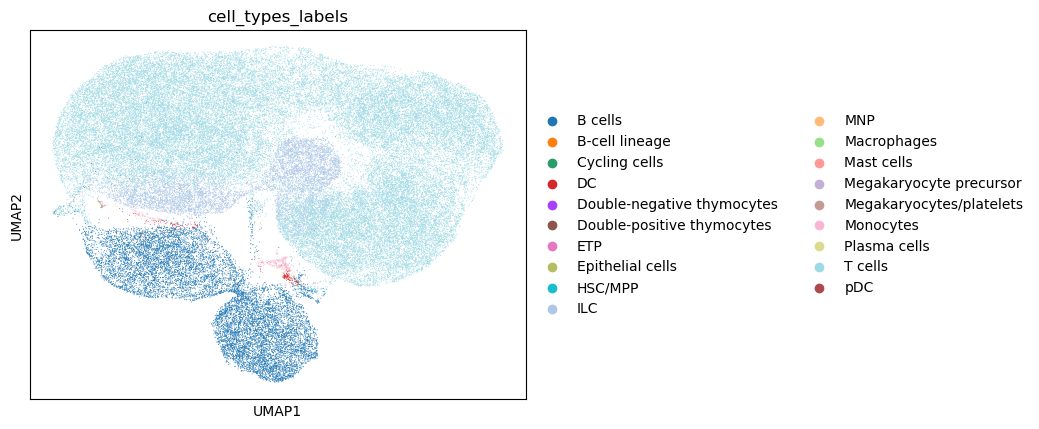

In [28]:
sc.pl.umap(adata_ref_GSE239626_new, color=['cell_types_labels'])

### Create subsets

In [29]:
# reordering the adata_ref_GSE239626_new.var to match the adata_GSE138266_new.var
adata_GSE138266_new = adata_GSE138266_new[:, adata_ref_GSE239626_new.var.index]

In [30]:
adata_GSE138266_new.X

<814177x37944 sparse matrix of type '<class 'numpy.float64'>'
	with 78355676 stored elements in Compressed Sparse Row format>

In [31]:
adata_pbmc_ms = adata_GSE138266_new[(adata_GSE138266_new.obs['cell_type']=='PBMC') & (adata_GSE138266_new.obs['disease']=='MS')]
adata_csf_ms = adata_GSE138266_new[(adata_GSE138266_new.obs['cell_type']=='CSF') & (adata_GSE138266_new.obs['disease']=='MS')]
adata_pbmc_pst = adata_GSE138266_new[(adata_GSE138266_new.obs['cell_type']=='PBMC')&(adata_GSE138266_new.obs['disease']=='PST')]
#adata_csf_pst = adata_GSE138266_new[(adata_GSE138266_new.obs['cell_type']=='CSF')&(adata_GSE138266_new.obs['disease']=='PST')]
adata_pbmc_ptc = adata_GSE138266_new[(adata_GSE138266_new.obs['cell_type']=='PBMC')&(adata_GSE138266_new.obs['disease']=='PTC')]
adata_csf_ptc = adata_GSE138266_new[(adata_GSE138266_new.obs['cell_type']=='CSF')&(adata_GSE138266_new.obs['disease']=='PTC')]

adata_GSE138266_splitted_list = [adata_pbmc_ms, adata_csf_ms, adata_pbmc_pst, adata_pbmc_ptc, adata_csf_ptc]

In [50]:
np.array([ann.n_obs for ann in adata_GSE138266_splitted_list]).sum()

68038

In [32]:
import sklearn.utils.sparsefuncs as sparsefuncs

def unbiased_estimator(X):
    mean, var = sparsefuncs.mean_variance_axis(X, 0)
    # enforce R convention (unbiased estimator) for variance
    var *= (X.shape[0]/(X.shape[0]-1))
    return mean, var

def visualize_statistic(X):
    print(f'Mean: {X.mean()}, Min: {X.min()}, Max: {X.max()}')

In [33]:
print('Reference dataset: ')
visualize_statistic(adata_GSE138266_new.X)

for i, adata_GSE138266_new in enumerate(adata_GSE138266_splitted_list):
    print(f'Subset {i}: {adata_GSE138266_new.shape[0]} cells')
    visualize_statistic(adata_GSE138266_new.X)

Reference dataset: 
Mean: 0.0044755522739973646, Min: 0.0, Max: 9.210440366976517
Subset 0: 25831 cells
Mean: 0.04835238115937548, Min: 0.0, Max: 9.094836434598108
Subset 1: 19366 cells
Mean: 0.048652507364394665, Min: 0.0, Max: 9.086144794967275
Subset 2: 5892 cells
Mean: 0.03958130142041144, Min: 0.0, Max: 9.132046225258232
Subset 3: 11246 cells
Mean: 0.03966082746253642, Min: 0.0, Max: 9.11527668056243
Subset 4: 5703 cells
Mean: 0.04411379405523066, Min: 0.0, Max: 9.08611433130941


### Transfer Labels

In [34]:
def transfer_labels(adata_ref, adata_new):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        # integrate the new dataset with the reference dataset
        print('Integrating the new dataset with the reference dataset...')
        sc.tl.ingest(adata_new, adata_ref, obs='cell_types_labels')

        # concat the datasets
        print('Concatenating the datasets...')
        adata_concat = adata_ref.concatenate(adata_new,
            batch_categories=['reference_GSE239626', 'GSE138266'])

        print('Transfering the labels...')
        adata_concat.obs.cell_types_labels = adata_concat.obs.cell_types_labels.astype('category')
        adata_concat.obs.cell_types_labels.cat.reorder_categories(
            adata_ref.obs.cell_types_labels.cat.categories)  # fix category ordering
    
    return adata_concat

def visulize_umap(adata_GSE138266_new, color=['batch', 'cell_types_labels'], ncols=1):
    sc.pl.umap(adata_GSE138266_new, color=color, ncols=ncols)

In [35]:
adata_concat_list = []

for adata in adata_GSE138266_splitted_list:
    adata_concat = transfer_labels(adata_ref_GSE239626_new, adata)

    print('Computing PCA, BBKNN, and UMAP...')
    sc.tl.pca(adata_concat)
    bbknn.bbknn(adata_concat, batch_key='batch')
    sc.tl.umap(adata_concat, random_state=RANDOM_STATE)

    adata_concat_list.append(adata_concat)

Integrating the new dataset with the reference dataset...
Concatenating the datasets...
Transfering the labels...
Computing PCA, BBKNN, and UMAP...
Integrating the new dataset with the reference dataset...
Concatenating the datasets...
Transfering the labels...
Computing PCA, BBKNN, and UMAP...
Integrating the new dataset with the reference dataset...
Concatenating the datasets...
Transfering the labels...
Computing PCA, BBKNN, and UMAP...
Integrating the new dataset with the reference dataset...
Concatenating the datasets...
Transfering the labels...
Computing PCA, BBKNN, and UMAP...
Integrating the new dataset with the reference dataset...
Concatenating the datasets...
Transfering the labels...
Computing PCA, BBKNN, and UMAP...


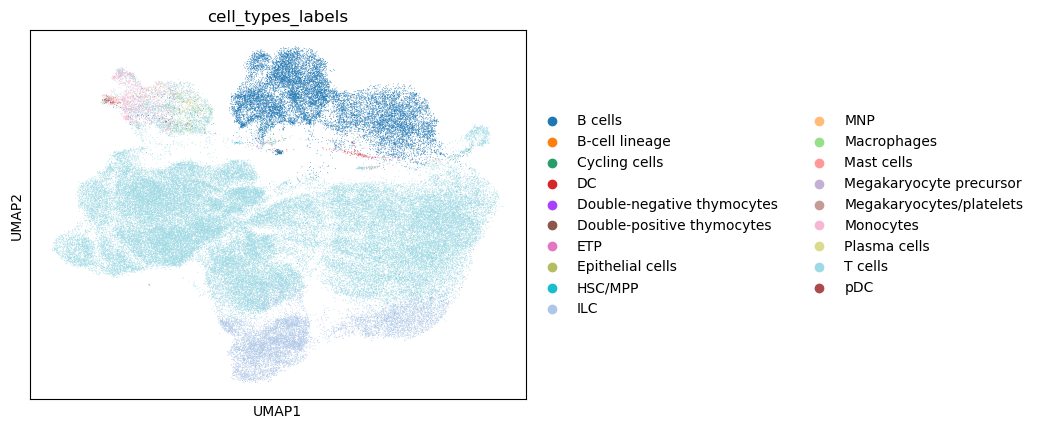

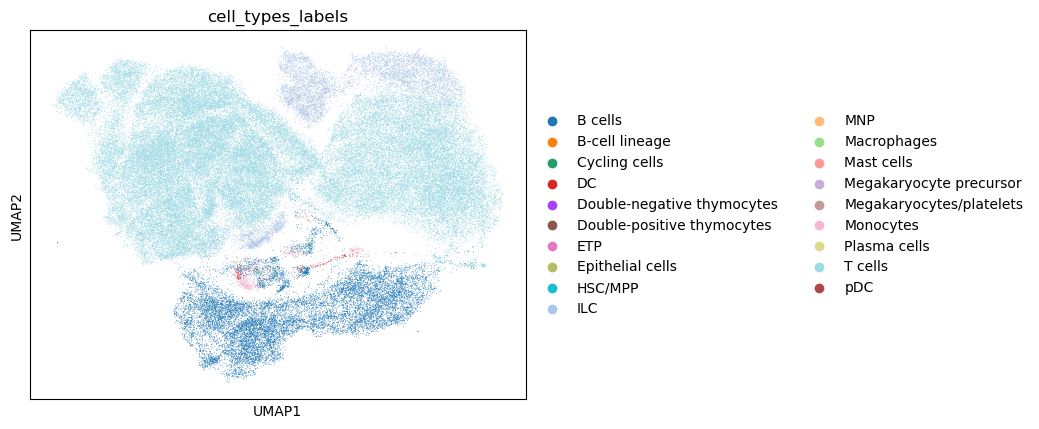

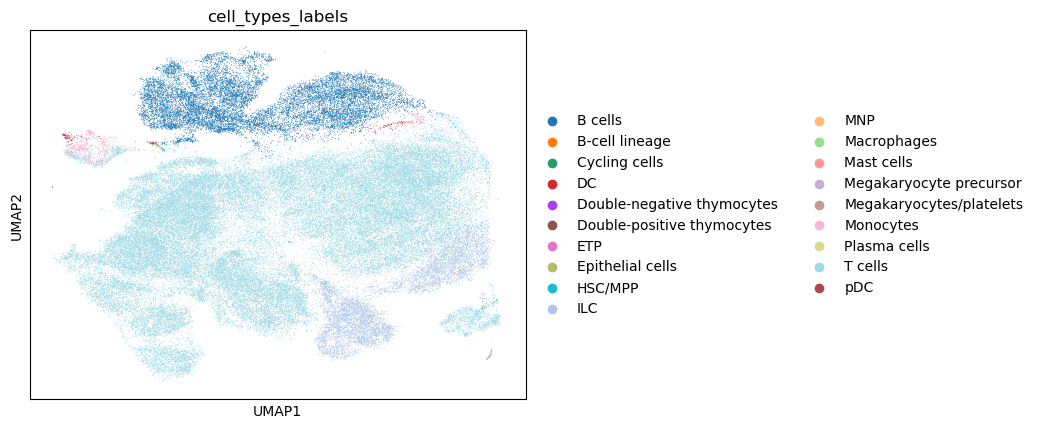

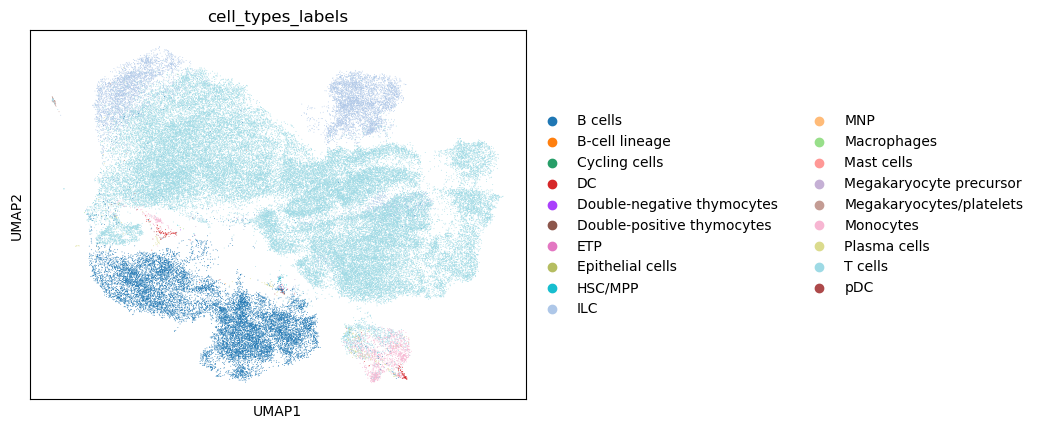

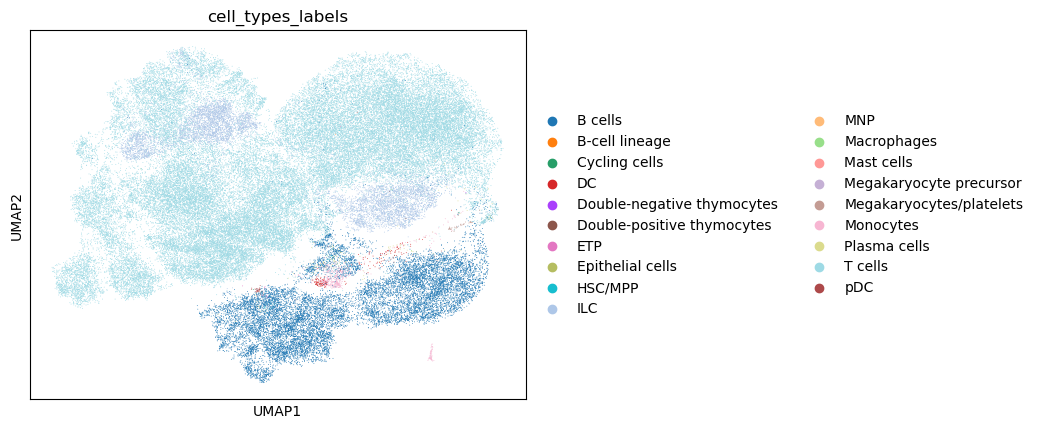

In [36]:
for adata_results in adata_concat_list:
    visulize_umap(adata_results, color=['cell_types_labels'], ncols=1)

### Final dataset

In [53]:
adata_ref_GSE239626_new

AnnData object with n_obs × n_vars = 72317 × 37944
    obs: 'cell_types_labels'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_types_labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [57]:
adata_transcriptomic = adata_ref_GSE239626_new

for subset in [adata_csf_ms, adata_pbmc_ms, adata_pbmc_pst, adata_csf_ptc, adata_pbmc_ptc]:
    # estrapolate from dataset only the cells in batch 'GSE138266'
    subset_GSE138266 = subset[subset.obs['dataset'] == 'GSE138266']

    # concatenate the transcriptomic dataset with the subset
    adata_transcriptomic = adata_transcriptomic.concatenate(subset_GSE138266, batch_key='batch')

C:\Users\giuli\AppData\Local\Temp\ipykernel_12328\1224359768.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_transcriptomic = adata_transcriptomic.concatenate(subset_GSE138266, batch_key='batch')
C:\Users\giuli\AppData\Local\Temp\ipykernel_12328\1224359768.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_transcriptomic = adata_transcriptomic.concatenate(subset_GSE138266, batch_key='batch')
C:\Users\giuli\AppData\Local\Temp\ipykernel_12328\1224359768.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for

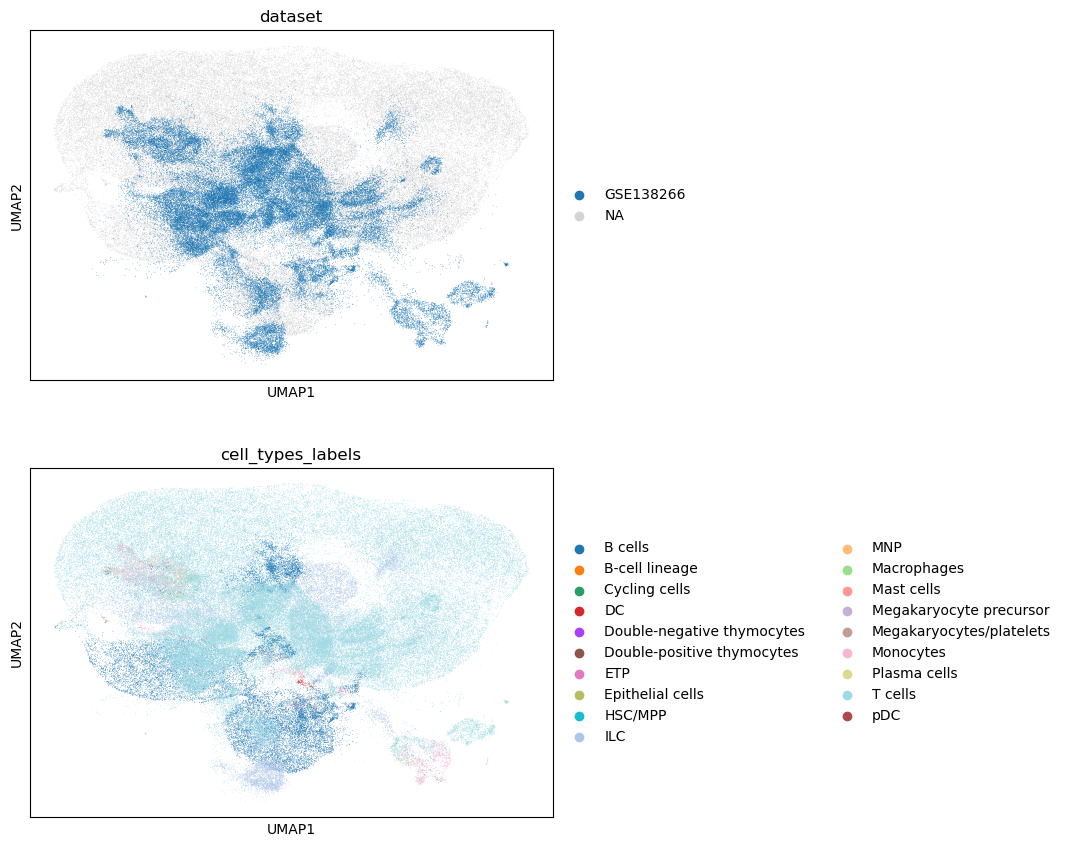

In [45]:
visulize_umap(adata_transcriptomic, color=['dataset', 'cell_types_labels'], ncols=1)

In [39]:
adata_transcriptomic


AnnData object with n_obs × n_vars = 140355 × 37944
    obs: 'cell_types_labels', 'sample', 'patient', 'dataset', 'disease', 'cell_type', 'batch'
    uns: 'batch_colors', 'cell_types_labels_colors'
    obsm: 'X_umap', 'X_pca'

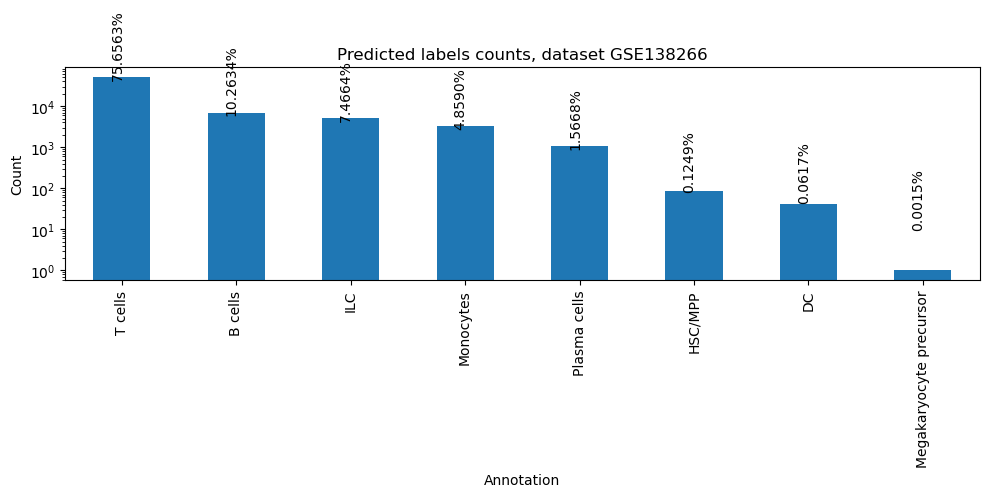

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.gca()
adata_transcriptomic[adata_transcriptomic.obs['dataset'] == 'GSE138266'].obs['cell_types_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata_transcriptomic[adata_transcriptomic.obs['dataset'] == 'GSE138266'].obs['cell_types_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts, dataset GSE138266')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [58]:
# save prediction
predictions = adata_transcriptomic[adata_transcriptomic.obs['dataset']=='GSE138266'].obs['cell_types_labels']
predictions.to_csv('results/celltypist_labels_from_transcriptomic_GSE138266.csv')

In [59]:
predictions

AAACCTGAGTGGGCTA-1-MS19270-CSF-1-0-0-0-0      T cells
AAACCTGAGTGTTAGA-1-MS19270-CSF-1-0-0-0-0      T cells
AAACCTGGTCGCGTGT-1-MS19270-CSF-1-0-0-0-0    Monocytes
AAACCTGGTCTCCACT-1-MS19270-CSF-1-0-0-0-0      T cells
AAACCTGGTTTACTCT-1-MS19270-CSF-1-0-0-0-0      T cells
                                              ...    
TTTGCGCGTGCAACGA-1-PTC85037-PBMC-1            T cells
TTTGCGCTCCGTAGTA-1-PTC85037-PBMC-1            T cells
TTTGGTTCACCACGTG-1-PTC85037-PBMC-1                ILC
TTTGTCACACTGAAGG-1-PTC85037-PBMC-1            B cells
TTTGTCATCAGTTAGC-1-PTC85037-PBMC-1            T cells
Name: cell_types_labels, Length: 68038, dtype: category
Categories (8, object): ['B cells', 'DC', 'HSC/MPP', 'ILC', 'Megakaryocyte precursor', 'Monocytes', 'Plasma cells', 'T cells']

In [43]:
sc.tl.embedding_density(adata_transcriptomic, groupby='dataset')

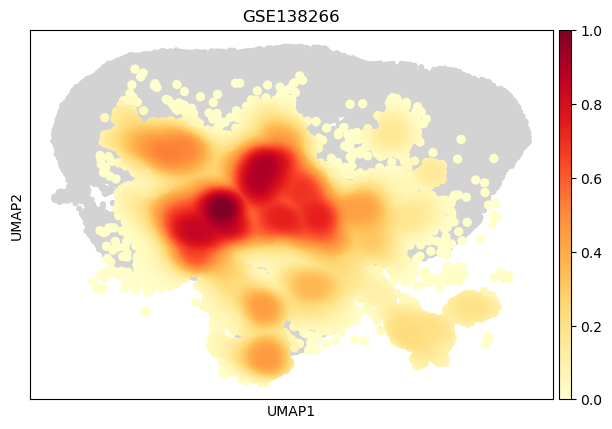

In [44]:
sc.pl.embedding_density(adata_transcriptomic, groupby = 'dataset')